In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch # PyTorch
import torch.nn as nn # To build custom models
import torch.optim as optim # Optimizers to make parameter updates
from torch.optim.lr_scheduler import StepLR # LR scheduler to change lr while training
from torch.utils.data import DataLoader # For batching the input data
from torchvision import datasets, models, transforms # To build custom dataset, get pretrained models,
                                                    # and to build data augmentation pipline
import matplotlib.pyplot as plt # Plotiing images
import os # To iterate through dirs

# Enable cuda for torch
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Declare device to GPU if available else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
# Model definition class
class DNN(nn.Module):
    def __init__(self, use_pretrained = True, nb_outs = 1):
        super(DNN, self).__init__()
        
        # Pretrained lightweight backbone
        self.net = models.mobilenet_v2(pretrained = use_pretrained, progress=True)
        
        # Changing classifier to spit one number
        self.net.classifier = nn.Sequential(nn.Dropout(p=0.2), nn.Linear(1280, 1, bias=False))
        
    def forward(self, x):
        x = self.net(x)
        return x
        
model = DNN()

# Moving model to device
model = model.to(device)

# Freeze initial layers to finetune the model 
for i, layer in enumerate(model.parameters()):
    if i < 150:
        layer.requires_grad_ = False
        # print(i, layer.shape)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/checkpoints/mobilenet_v2-b0353104.pth


In [3]:
# Normalization factors for pretrained model
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

# Function to visulize batched data
def visulize_batch(x):
    for i in range(x.shape[0]):
        img = x[i, :, :, :].numpy().transpose((1,2,0))
        img = (img*std_nums) + mean_nums
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.show()
        
        
# Transforms to apply on train images (data augmentation and data prep to feed it to the model)
train_transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees = 20, translate=(.1, .1), scale=(0.8, 1.2), shear=[-10, 10, -10, 10]),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean_nums, std_nums)
])

# Transforms to apply on validation images
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean_nums, std_nums)
])


# Defining train and val datasets
train_dataset = datasets.ImageFolder("../input/face-mask-12k-images-dataset/Face Mask Dataset/Train", transform=train_transform)
val_dataset = datasets.ImageFolder("../input/face-mask-12k-images-dataset/Face Mask Dataset/Validation", transform=val_transform)

# Defining train and val loaders to make batches of data
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size = 64, shuffle=True, num_workers=4)

tensor([0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0,
        1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0])


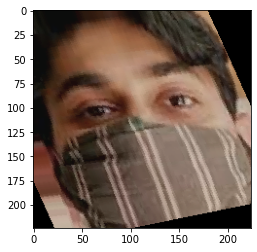

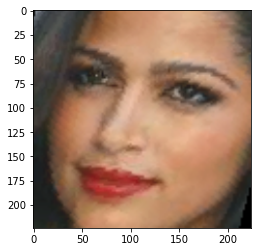

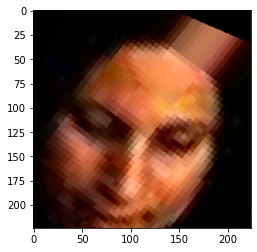

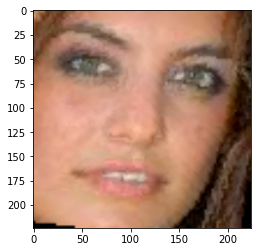

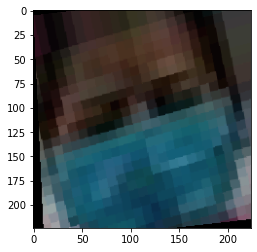

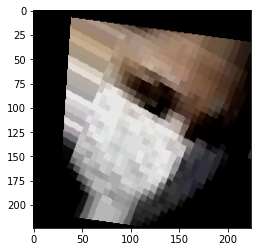

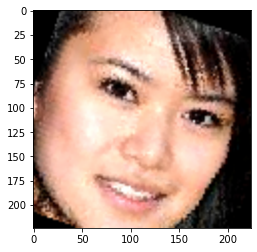

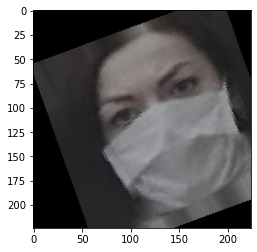

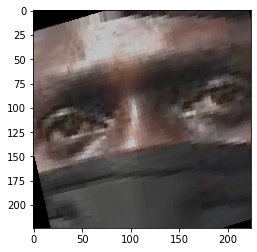

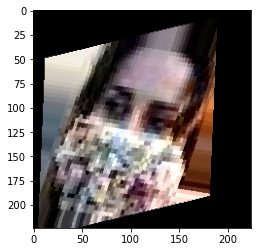

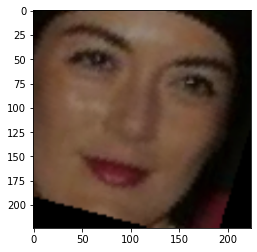

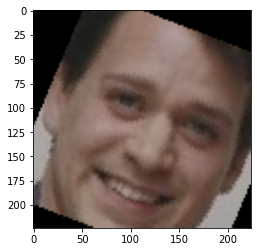

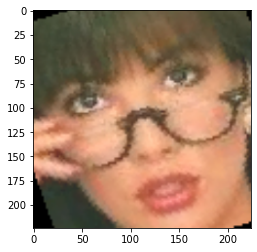

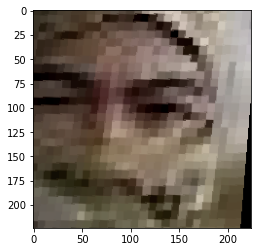

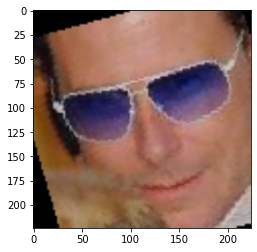

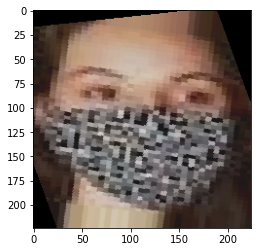

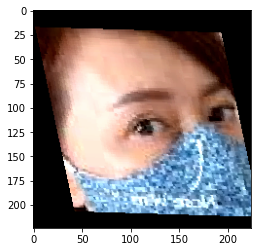

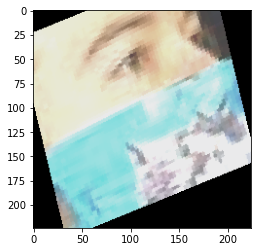

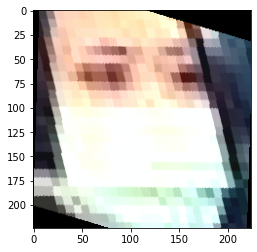

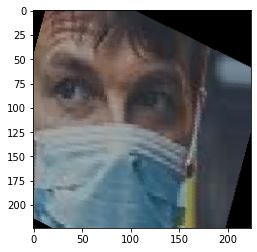

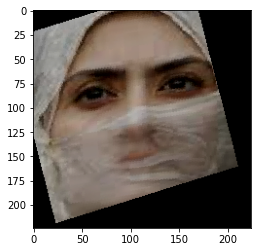

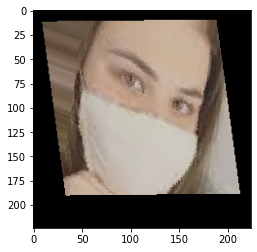

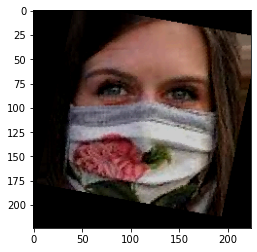

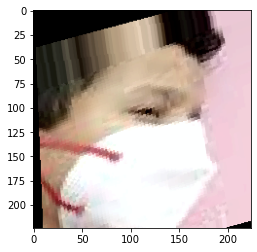

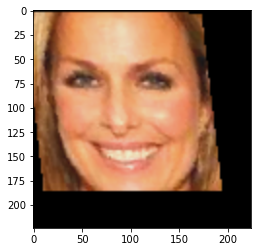

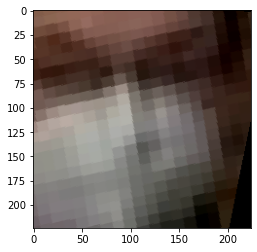

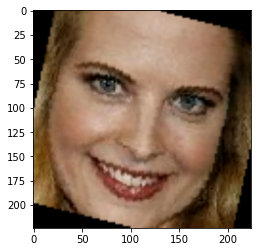

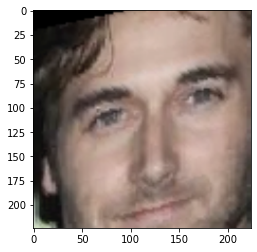

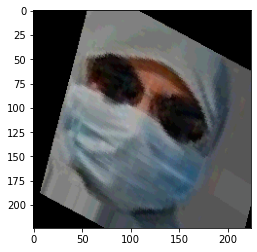

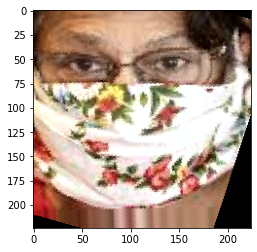

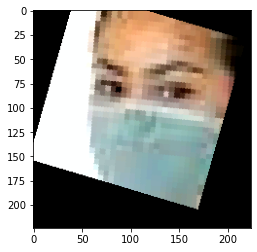

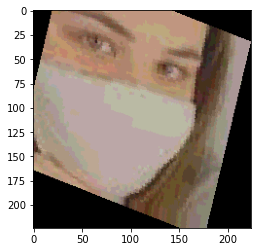

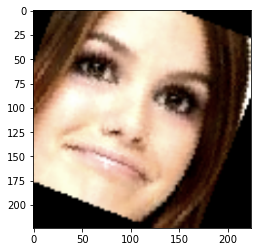

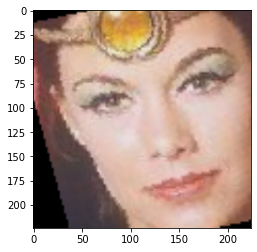

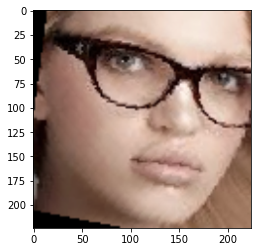

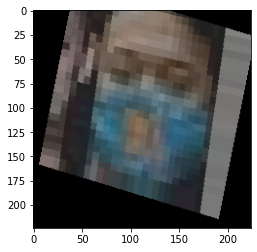

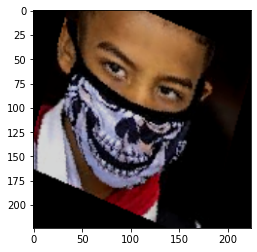

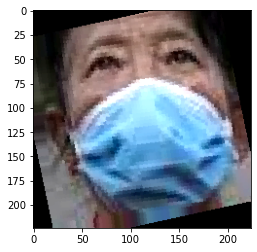

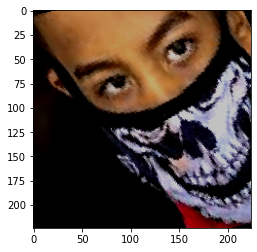

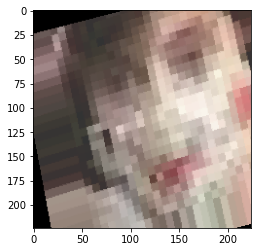

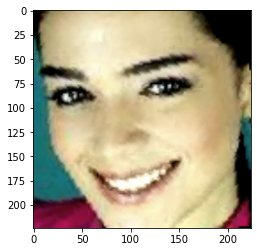

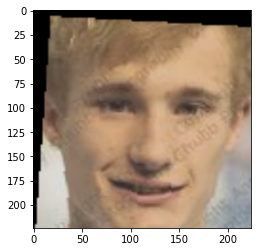

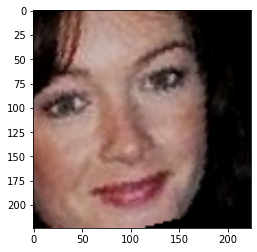

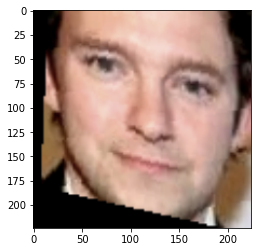

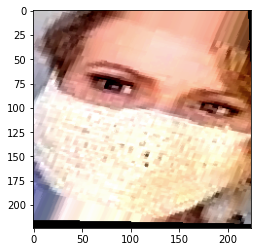

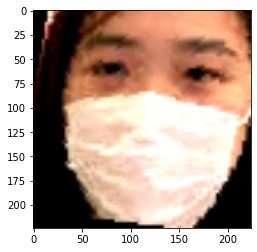

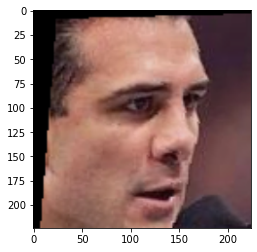

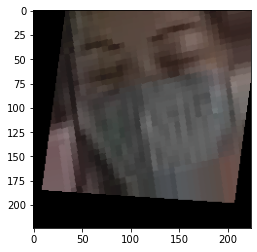

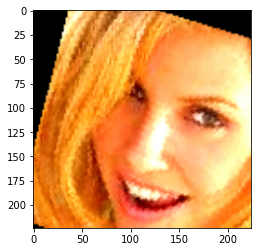

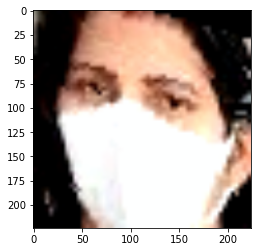

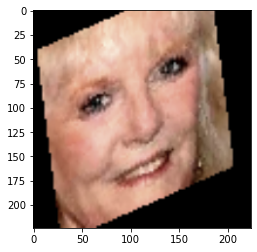

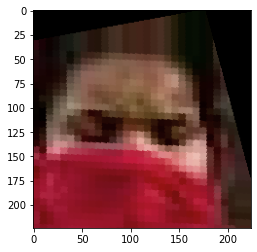

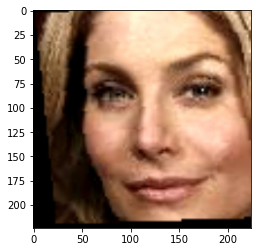

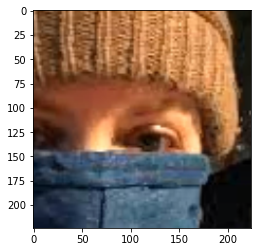

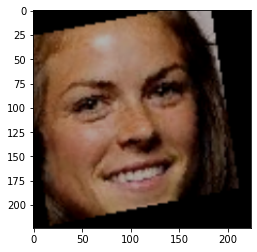

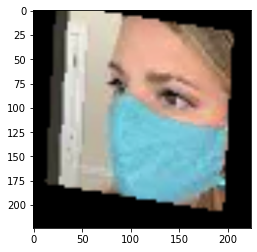

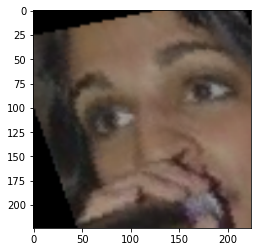

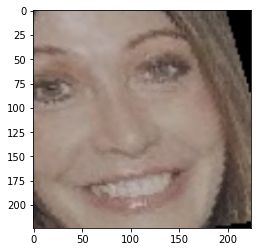

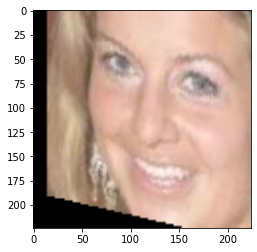

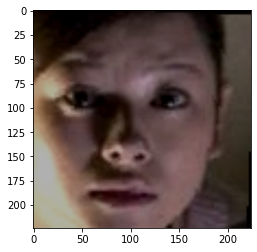

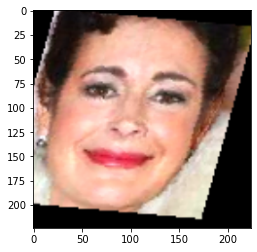

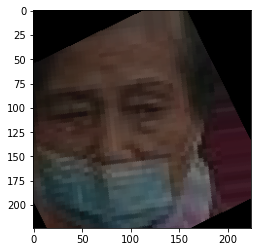

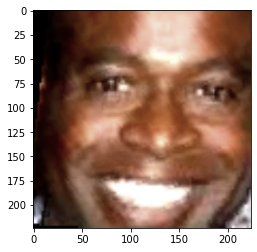

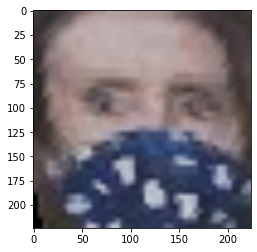

In [4]:
# for x, target in train_loader:
#     print(target)
#     visulize_batch(x)
#     break

In [5]:
# Binary cross entropy loss
criterion = nn.BCEWithLogitsLoss()

# Adam optimizer to make weight updates
optimizer = optim.Adam(model.parameters())

# Lr scheduler to decrease lr every 2 epochs
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

In [ ]:
# Finetuning of model

# Total epochs to train for
num_epochs = 10

# Keep note of minimum val loss every epoch
min_val_loss = np.inf

# Training loop
for i in range(num_epochs):
    train_loss = 0.
    val_loss = 0.
    
    # Switch model to training mode
    model.train()
    
    # Iterating through training data
    for inputs, labels in train_loader:
        
        # Move input data to device
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Zero out accumulated gradients
        optimizer.zero_grad()
        
        # Forward pass
        preds = model(inputs).squeeze(1)
        labels = labels.type_as(preds)
        
        # Computing loss
        loss = criterion(preds, labels)
        
        # Add it to train loss
        train_loss += (loss.item()*inputs.size(0))
        
        # Compute gradients by backpropagating
        loss.backward()
        
        # Make weight updates
        optimizer.step()
        
    # Switch model to val mode
    model.eval()
    
    # Analogously iterating through val data (Except backprop and changing weights)
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        preds = model(inputs).squeeze(1)
        labels = labels.type_as(preds)
        
        loss = criterion(preds, labels)
        
        val_loss += (loss.item()*inputs.size(0))
        
    # If current val loss is lesser than min val loss save the model
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        torch.save(model.state_dict(), 'Mobilenet_v2_Mask_Detection.pt')
    
    # Change lr based on init
    scheduler.step()
        
    # Print epoch number, train loss and val loss
    print('Epoch {}:\tTrain Loss: {:.6f}\tVal Loss: {:.6f}'.format(i+1, train_loss/len(train_dataset), val_loss/len(val_dataset)))

Epoch 1:	Train Loss: 0.034720	Val Loss: 0.012298
Epoch 2:	Train Loss: 0.018748	Val Loss: 0.007046
Epoch 3:	Train Loss: 0.010095	Val Loss: 0.001444
Epoch 4:	Train Loss: 0.005280	Val Loss: 0.000748
Epoch 5:	Train Loss: 0.005533	Val Loss: 0.000664
Epoch 6:	Train Loss: 0.004512	Val Loss: 0.000446
Epoch 7:	Train Loss: 0.003731	Val Loss: 0.000443
Epoch 8:	Train Loss: 0.004174	Val Loss: 0.000497
Epoch 9:	Train Loss: 0.003681	Val Loss: 0.000410
